#  Activation propagation through network

Say that we want to model the probability density $p(\theta|c)$ of some observable $\theta$ conditioned on some physics parameter $c$. We model this using a Gaussian mixture model $p_{\phi(c)}(\theta)$, where the Gaussian parameters $\phi$ are modelled using neural networks taking only $c$ as an input. We have several aims for our architecture and initial conditions:
- The probability distribution must be stable (i.e. provide sensible values for any physically meaningful $c$). This means that the initial output values of the network outputs must not be too large.
- We must be able to learn a dependence on $c$, so the output must have some initial dependence on $c$, or at least a significant initial gradient
- Training must result in a generalisable solution, which means interpolating between initial datapoints must follow a sensible (i.e. smooth and ~linear) induction bias. This means that the modelling of two similar values of $c$ should be achieved by smoothly deforming the Gaussians, i.e. the output values should be relatively similar. Again, this means that the initial output values should be small but not vanishing.
- The network should start in a non-degenerate state, i.e. with non-degenerate neurons (as degenerate neurons will always have the same gradient and learn identically, and thus only provide the capacity of a single neuron. 

We therefore wish our network to be instantiated in a state where
- output values are small but not vanishing
- output values retain a dependence on $c$
- output values retain a gradient w.r.t. $c$
- neuron values are randomly assigned from some distribution

---

**Brief:** With these goals in mind, in this notebook we study how activations propagate through a network given different configurations and initial conditions.

---

In [102]:
#  Required imports

import sys

import numpy as np

from scipy import stats as stats

from matplotlib import pyplot as plt

In [128]:
# Define activation functions

def activate_linear (x) :
    '''pass input values x through a linear activation function'''
    return x

def activate_leakyrelu (x, c=0.2) :
    '''pass input values x through a LeakyReLU activation function, where c is the response gradient for negative inputs'''
    if type(x) == np.ndarray :
        return np.array([activate_leakyrelu(xp) for xp in x])
    if x < 0 : return c*x
    return x

def activate_softmax (x, c=0.2) :
    '''pass input values x through a SoftMax activation function'''
    assert type(x) == np.ndarray , f"Input type {type(x)} not recognised"
    if len(x.shape) > 1 :
        return np.array([activate_softmax(xp) for xp in x])
    return np.exp(x) / np.sum(np.exp(x))


Initially, consider that the activation function is simply linear. If we have zero initial biases, then

\begin{align}
  I^{(l)}_i  & = \sum_{j=1}^{N_j} w^{(l)}_{ij}  A^{(l-1)}_{j}  \\
  I^{(l+1)}_i  & = \sum_{i=1}^{N_i} \sum_{j=1}^{N_j} w^{(l+1)}_{ij} w^{(l)}_{jk}  A^{(l-1)}_{k}  \\
\end{align}

If the initial weights at layer $i+1$ are set to some constant $c_i=1$, then the summation will cause activations to explode as we propagate throught the network. We can counter this by setting $c_i=\frac{1}{N_i}$. Then


\begin{align}
  I^{(l)}_i  & = \sum_{j=1}^{N_j}\frac{1}{N_j} A^{(l-1)}_{j}  &=   \langle A^{(l-1)} \rangle \\
  I^{(l+1)}_i  & = \sum_{i=1}^{N_i} \sum_{j=1}^{N_j} \frac{1}{N_i \cdot N_j}  A^{(l-1)}_{k}  &=   \langle A^{(l-1)} \rangle  \\
\end{align}

In [10]:
#  Show that this is true


#  Define input values
x    = np.random.normal(size=(8,))
N_in = len(x)


#  Print input values
print("x is " + ", ".join([f"{xp:.2f}" for xp in x]))
print(f"<x> is {np.mean(x):.2f}")


#  Propagate values to the next layer, and print activation values
N1 = 10
w1 = np.full(fill_value=1/N_in, shape=(N1, N_in))
I1 = np.matmul(w1, x)
A1 = activate_linear(I1)
print("\nA1 is " + ", ".join([f"{xp:.2f}" for xp in A1]))


#  Propagate values to the next layer, and print activation values
N2 = 40
w2 = np.full(fill_value=1/N1, shape=(N2, N1))
I2 = np.matmul(w2, A1)
A2 = activate_linear(I2)
print("\nA2 is " + ", ".join([f"{xp:.2f}" for xp in A2]))


#  Propagate values to the next layer, and print activation values
N3 = 20
w3 = np.full(fill_value=1/N2, shape=(N3, N2))
I3 = np.matmul(w3, A2)
A3 = activate_linear(I3)
print("\nA3 is " + ", ".join([f"{xp:.2f}" for xp in A3]))


x is -1.25, 1.50, -0.40, 1.14, 1.54, 0.33, 0.68, -0.56
<x> is 0.37

A1 is 0.37, 0.37, 0.37, 0.37, 0.37, 0.37, 0.37, 0.37, 0.37, 0.37

A2 is 0.37, 0.37, 0.37, 0.37, 0.37, 0.37, 0.37, 0.37, 0.37, 0.37, 0.37, 0.37, 0.37, 0.37, 0.37, 0.37, 0.37, 0.37, 0.37, 0.37, 0.37, 0.37, 0.37, 0.37, 0.37, 0.37, 0.37, 0.37, 0.37, 0.37, 0.37, 0.37, 0.37, 0.37, 0.37, 0.37, 0.37, 0.37, 0.37, 0.37

A3 is 0.37, 0.37, 0.37, 0.37, 0.37, 0.37, 0.37, 0.37, 0.37, 0.37, 0.37, 0.37, 0.37, 0.37, 0.37, 0.37, 0.37, 0.37, 0.37, 0.37


Now say that we have non-zero biases. Then

\begin{align}
  I^{(l)}_i  & = \sum_{j=1}^{N_j}\frac{1}{N_j} A^{(l-1)}_{j}  ~+~  b^{(l)}_i  \\
  &=   \langle A^{(l-1)} \rangle ~+~  b^{(l)}_i \\
  I^{(l+1)}_i  & = \sum_{j=1}^{N_j}\frac{1}{N_j} \left( \sum_{k=1}^{N_k}\frac{1}{N_k} A^{(l-1)}_{k}  ~+~  b^{(l)}_j \right) ~+~ b^{(l+1)}_i  \\
  & = \sum_{j=1}^{N_j} \sum_{k=1}^{N_k} \frac{A^{(l-1)}_{k}}{N_j \cdot N_k} ~+~ \sum_{j=1}^{N_j} \frac{b^{(l)}_j}{N_j} ~+~ b^{(l+1)}_i  \\
  & = \langle A^{(l-1)} \rangle ~+~ \langle b^{(l)} \rangle ~+~ b^{(l+1)}_i  \\
\end{align}

and so the values will stay relatively stable if $b$ are sampled from a distribution with $0$ mean. 

x is 0.35, 2.16, -2.51, -0.88, 1.17
<x> is 0.06

A1 with mean 0.05 and std 0.98 

A2 with mean 0.06 and std 1.00 

A3 with mean 0.04 and std 1.00 


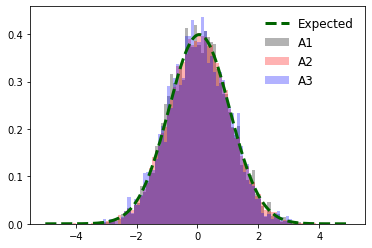

In [26]:
#  Show that this is true


#  Define input values
x    = np.random.normal(size=(5,))
N_in = len(x)


#  Print input values
print("x is " + ", ".join([f"{xp:.2f}" for xp in x]))
print(f"<x> is {np.mean(x):.2f}")


#  Propagate values to the next layer, and print activation values
N1 = 3000
w1 = np.full(fill_value=1/N_in, shape=(N1, N_in))
b1 = np.random.normal(size=(N1,))
I1 = np.matmul(w1, x) + b1
A1 = activate_linear(I1)
print(f"\nA1 with mean {np.mean(A1):.2f} and std {np.std(A1):.2f} ")


#  Propagate values to the next layer, and print activation values
N2 = 15000
w2 = np.full(fill_value=1/N1, shape=(N2, N1))
b2 = np.random.normal(size=(N2,))
I2 = np.matmul(w2, A1) + b2
A2 = activate_linear(I2)
print(f"\nA2 with mean {np.mean(A2):.2f} and std {np.std(A2):.2f} ")


#  Propagate values to the next layer, and print activation values
N3 = 3000
w3 = np.full(fill_value=1/N2, shape=(N3, N2))
b3 = np.random.normal(size=(N3,))
I3 = np.matmul(w3, A2) + b3
A3 = activate_linear(I3)
print(f"\nA3 with mean {np.mean(A3):.2f} and std {np.std(A3):.2f} ")


#  Plot activation spectra, and compare with our expectation
fig = plt.figure(figsize=(6, 4))
ax  = fig.add_subplot(1, 1, 1)
ax.hist(A1, bins=np.linspace(-5, 5, 101), density=True, alpha=0.3, color="k", label="A1")
ax.hist(A2, bins=np.linspace(-5, 5, 101), density=True, alpha=0.3, color="r", label="A2")
ax.hist(A3, bins=np.linspace(-5, 5, 101), density=True, alpha=0.3, color="b", label="A3")
pdf_x = np.linspace(-5, 5, 1001)
ax.plot(pdf_x, stats.norm.pdf(pdf_x, loc=np.mean(x)), "--", lw=3, color="darkgreen", label="Expected")
ax.legend(loc="upper right", frameon=False, fontsize=12)
plt.show()


Now return the biases to $0$, and obtain the weights by randomly sampling from a uniform distribution, symmetric around $0$. This means that some of the weights will now be negative and cancel the effect of positive weights, and the mean of all weights will be $0$. Even though these cancel on average, numbers will still propagate through layers due to the finite variance (stated another way, any stochastically chosen state with a finite number of neurons will not achieve a perfect cancellation, and so some non-zero activations will be present and propagate to the next layer). 

Say that $w^{(l)}_{ij} ~ [-c_l,~c_l]$. Then
\begin{align}
  I^{(l)}_i  & = \sum_{j=1}^{N_j} w^{(l)}_{ij}  A^{(l-1)}_{j}  \\
  &  \xrightarrow[N_j~\rightarrow~\infty]{} \int_{-\infty}^{+\infty} w^{(l)}_{i}(j) \cdot A^{(l-1)}(j) ~{\rm d}j \\
\end{align}

and we see that the distribution of $I^{(l)}_i$ is the convolution of $w^{(l)}_{ij}$ with $A^{(l-1)}_{j}$.

Let us normalise $x$ onto the interval $[0.5,~1.5]$, so that all inputs start approximately equally weighted with a natural scale of $1$. Furthermore, we avoid any initial values of $0$ which leads to degenerate neurons in the first layer (all neurons multiplied by $0$ will simply output the value of their bias, which is initially $0$ for all neurons, and so they evolve degenerately).

For the first layer, 
\begin{align}
  I^{(1)}_i  & = \sum_j w^{(1)}_{ij} ~~ x_j \\
  \mathbb{E}\big[ I^{(1)}_i \big]  & = \mathbb{E}\big[ \sum_j w^{(1)}_{ij} ~~ x_j \big] \\
  & = \int \left( \sum_j w^{(1)}_j~~ x_j \right) ~\prod_j p\left(w^{(1)}_j\right)  ~\prod_j{\rm d}w^{(1)}_j \\
  & = \frac{1}{2c} \cdot \left( \sum_j x_j \right) \cdot \int_{-c_1}^{+c_1} w ~{\rm d}w \\
   & = 0 \\
  \mathbb{E}\big[ |I^{(1)}_i| \big]  & = \int \big| \sum_j w^{(1)}_j~~ x_j \big| ~\prod_j p\left(w^{(1)}_j\right)  ~\prod_j{\rm d}w^{(1)}_j \\
  &  \frac{1}{\left(2c\right)^3} \int \big| \sum_j w^{(1)}_j~~ x_j \big|  ~\prod_j{\rm d}w^{(1)}_j \\
\end{align}



We can see that, whilst the distribution for $I_i^{(1)}$ will always have a mean of $0$, it's average magnitude is dependent on the distribution of $x_j$. This means that different input values will lead to different characteristic distributions of $I_i^{(1)}$. Let us show this...

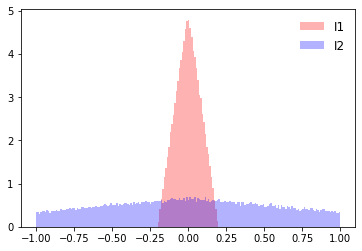

<|I1|> = 0.07,   std = 0.08
<|I2|> = 0.67,   std = 0.82


In [207]:
#  Create two different input vectors, with the same mean

x1 = [-0.1, 0.1]
x2 = [-1., 1.]

#  Create lots of uniformly distributed weights

w = np.random.uniform(low=-1, high=1, size=(100000, 2))

#  I = w * x

I1, I2 = np.matmul(w, x1), np.matmul(w, x2)

#  Plot and compare the different cases

fig = plt.figure(figsize=(6, 4))
ax  = fig.add_subplot(1, 1, 1)
ax.hist(I1, bins=np.linspace(-1, 1, 201), alpha=0.3, color="r", density=True, label="I1")
ax.hist(I2, bins=np.linspace(-1, 1, 201), alpha=0.3, color="b", density=True, label="I2")
ax.legend(loc="upper right", frameon=False, fontsize=12)
plt.show()

print(f"<|I1|> = {np.mean(np.fabs(I1)):.2f},   std = {np.std(I1):.2f}")
print(f"<|I2|> = {np.mean(np.fabs(I2)):.2f},   std = {np.std(I2):.2f}")


Clearly these are different. However, since our inputs are limited to the range $[0.5,~1.5]$, we can use the following heuristic 

\begin{equation}
c_1 = \frac{2.}{\sqrt{N_x}}
\end{equation}

or, when using a LeakyReLU activation function with a subdominant gradient of $g$,

\begin{equation}
c_1 = \frac{4.}{\left(1. + g\right) \cdot \sqrt{N_x}}
\end{equation}

This means that our $I_1$ distribution stays fairly constant as we scale the number of inputs $N_x$.

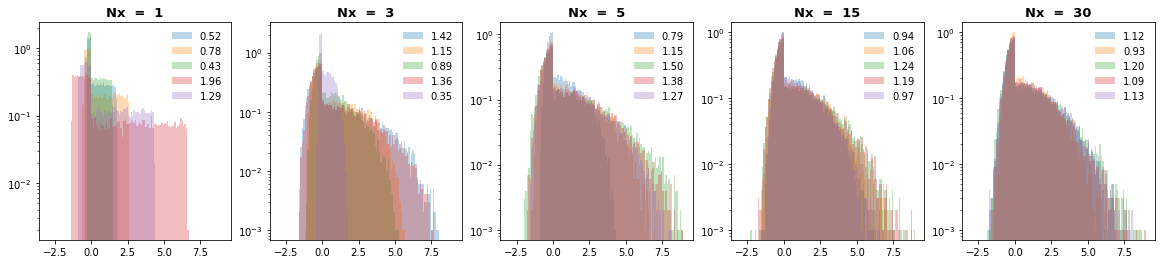

In [268]:
#  For a range of different input multiplicities Nx, and randomly sampled inputs, run a bunch of toys and
#      plot the distribution of A1 to show that they are comparable

num_x_toys = 5
num_W_toys = 100000
x_lo, x_hi = -2, 2

Nx = np.array([1, 3, 5, 15, 30], dtype=int)

fig = plt.figure(figsize=(4*len(Nx), 4))

for plot_idx, N0 in enumerate(Nx) :
    ax = fig.add_subplot(1, len(Nx), 1+plot_idx)
    ax.set_title(f"Nx  =  {N0}", fontsize=13, weight="bold")
    ax.set_yscale("log")
    for i in range(num_x_toys) :
        x  = np.random.uniform(low=x_lo, high=x_hi, size=(N0,))
        c1 = 4. / np.sqrt(N0) / (1 + 0.2)
        W1 = np.random.uniform(low=-c1, high=c1, size=(num_toys, N0))
        I1 = np.matmul(W1, x)
        A1 = activate_leakyrelu(I1)
        mean_in, mean_I, mean_out = np.mean(x), np.mean(np.fabs(I1)), np.mean(np.fabs(A1))
        ax.hist(A1, np.linspace(-3, 9, 121), alpha=0.3, density=True, label=f"{mean_out:.2f}")
    ax.legend(loc="upper right", frameon=False, fontsize=10)

plt.show()

Now for the second layer, $I_2$ will be a convolution of the weights $w^{(2)}$ and the distribution of $I_1$. We would like the second layer activations to be on a similar scale to the first, and so on throughout the network. At the same time, we want the weights to be sampled from a distribution with positive and negative values.

Unfortunately these goals are contradictory, as convolving the distributions above with a second distribution (which is not a delta function) will necessarily cause a smearing to take place. Furthermore, since the above distribution has a higghly non-standard form, it is difficult to propagate using maths, although we can state that we would like the Jacobian of the transformation to be close to one (to preserve length) or close to $\frac{N_i}{N_j}$ (to preserve magnitude of individual values). But this only works for square matrices, and in general we will have an increasing/decreasing number of neurons.

Still sampling between $-c_l$ and $c_l$, we can see that this constant should only depend on the number of *input* neurons, if we wish to preserve mean activation amplitudes. We will now create a heuristic which will keep things relatively stable.

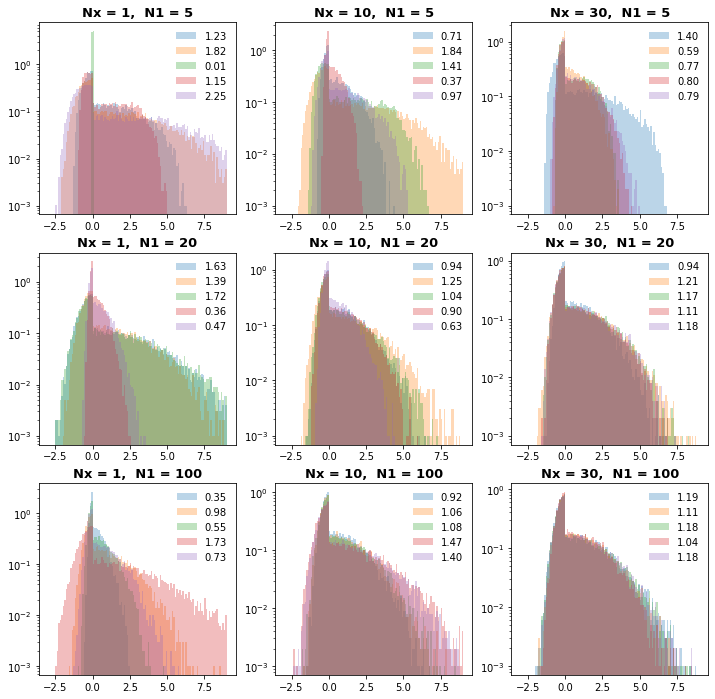

In [269]:
#  For a range of different input multiplicities Nx, and randomly sampled inputs, run a bunch of toys and
#      plot the distribution of A1 to show that they are comparable

num_x_toys = 5
num_W_toys = 100000

Nx  = np.array([1, 10, 30], dtype=int)
NI1 = np.array([5, 20, 100], dtype=int)

Nx, NI1 = np.meshgrid(Nx, NI1)
Nx, NI1 = Nx.flatten(), NI1.flatten()

fig = plt.figure(figsize=(12, 12))
for plot_idx, (N0, N1) in enumerate(zip(Nx, NI1)) :
    ax = fig.add_subplot(3, 3, 1+plot_idx)
    ax.set_title(f"Nx = {N0},  N1 = {N1}", fontsize=13, weight="bold")
    ax.set_yscale("log")
    for i in range(num_x_toys) :
        x  = np.random.uniform(low=x_lo, high=x_hi, size=(N0,))
        c1 = 4. / np.sqrt(N0) / (1 + 0.2)
        W1 = np.random.uniform(low=-c1, high=c1, size=(N1, N0))
        I1 = np.matmul(W1, x)
        A1 = activate_leakyrelu(I1)
        c2 = 3. / np.sqrt(N1) / (1 + 0.2)
        W2 = np.random.uniform(low=-c2, high=c2, size=(num_toys, N1))
        I2 = np.matmul(W2, A1)
        A2 = activate_leakyrelu(I2)
        mean_in, mean_I, mean_out = np.mean(x), np.mean(np.fabs(I2)), np.mean(np.fabs(A2))
        ax.hist(A2, np.linspace(-3, 9, 121), alpha=0.3, density=True, label=f"{mean_out:.2f}")
    ax.legend(loc="upper right", frameon=False, fontsize=10)

plt.show()

What if we now have many layers?

===   Layers are 10, 1   ===
***************  Toys complete  ***************

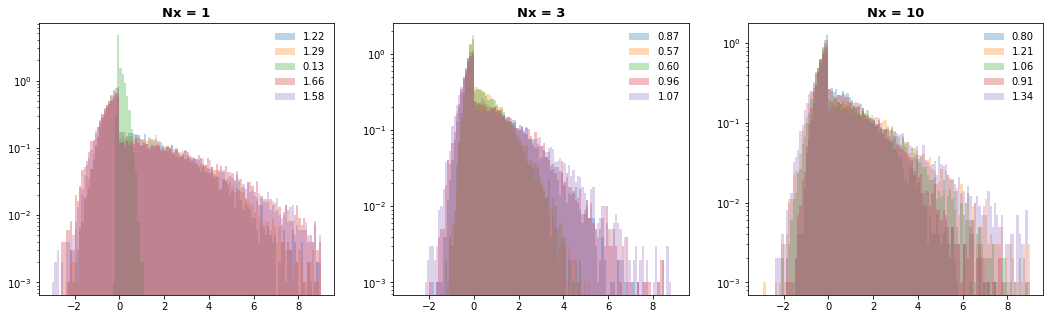

===   Layers are 5, 20, 20, 1   ===
***************  Toys complete  ***************

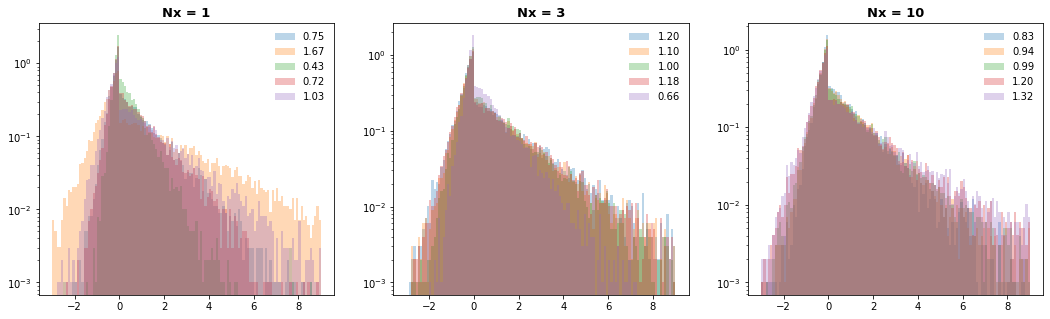

===   Layers are 10, 20, 40, 20, 10, 1   ===
***************  Toys complete  ***************

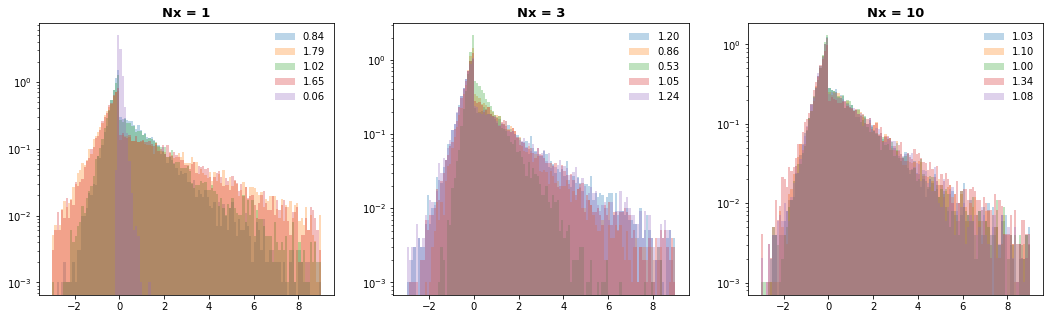

'layer_nodes = [20, 50, 500, 50, 20, 1]\nmake_plot(num_x_toys, num_W_toys, Nx, layer_nodes)'

In [270]:
#  For a range of different input multiplicities Nx, and randomly sampled inputs, run a bunch of toys and
#      plot the distribution of A1 to show that they are comparable


def make_plot (num_x_toys, num_W_toys, Nx, layer_nodes) :
    msg = "===   Layers are " + ", ".join([f"{l}" for l in layer_nodes]) + "   ==="
    print("="*len(msg)+"\n"+msg+"\n"+"="*len(msg))
    fig = plt.figure(figsize=(6*len(Nx), 5))
    for plot_idx, n in enumerate(Nx) :
        ax = fig.add_subplot(1, len(Nx), 1+plot_idx)
        ax.set_title(f"Nx = {n}", fontsize=13, weight="bold")
        ax.set_yscale("log")
        for i in range(num_x_toys) :
            sys.stdout.write(f"\r*****   Nin = {n},  toy {i+1} / {num_x_toys}   *****")
            initial_x = np.random.uniform(low=x_lo, high=x_hi, size=(n,))
            toys = []
            for j in range(num_W_toys) :
                x = initial_x.copy()
                for layer_idx, layer_n in enumerate(layer_nodes) :
                    Nin = len(x)
                    if layer_idx == 0 : c = 4. / np.sqrt(Nin) / (1 + 0.2)
                    else              : c = 3. / np.sqrt(Nin) / (1 + 0.2)
                    W = np.random.uniform(low=-c, high=c, size=(layer_n, Nin))
                    I = np.matmul(W, x)
                    x = activate_leakyrelu(I)
                toys.append(x.flatten()[0])
            mean_out = np.mean(np.fabs(toys))
            ax.hist(toys, np.linspace(-3, 9, 121), alpha=0.3, density=True, label=f"{mean_out:.2f}")
        ax.legend(loc="upper right", frameon=False, fontsize=10)
    sys.stdout.write("\r***************  Toys complete  ***************")
    plt.show()

    
num_x_toys  = 5
num_W_toys  = 10000
Nx          = np.array([1, 3, 10], dtype=int)

layer_nodes = [10, 1]
make_plot(num_x_toys, num_W_toys, Nx, layer_nodes)

layer_nodes = [5, 20, 20, 1]
make_plot(num_x_toys, num_W_toys, Nx, layer_nodes)

layer_nodes = [10, 20, 40, 20, 10, 1]
make_plot(num_x_toys, num_W_toys, Nx, layer_nodes)

'''layer_nodes = [20, 50, 500, 50, 20, 1]
make_plot(num_x_toys, num_W_toys, Nx, layer_nodes)'''


Since we have activations propagating consistently through a network with variable widths and depths, the final layer should simply scale the outputs of the previous layer by a reasonable amount (retaining the $\frac{1}{\sqrt{N}}$ dependence. We will now build our Gaussian mixture model, and experiment to figure out what scale the outputs should vary on.

In [276]:
first_instance = True

def get_gauss_params (in_val, num_gaussians=30, x_min=-5., x_max=5., Gauss_width_reduction_factor=8., initialise=False) :
    
    global first_instance
    if first_instance is True : initialise = True

    x_range = x_max - x_min
    
    Nin = 1
    x   = np.array([in_val])

    N1 = 10
    c1 = 4. / np.sqrt(Nin) / (1 + 0.2)
    if initialise : 
        W1 = np.random.uniform(low=-c, high=c, size=(N1, 1))
    I1 = np.matmul(W1, x)
    x = activate_leakyrelu(I1)
    
    N2 = 15
    c2 = 3. / np.sqrt(N1) / (1 + 0.2)
    if initialise : 
        W2 = np.random.uniform(low=-c, high=c, size=(N2, N1))
    I2 = np.matmul(W2, x)
    x = activate_leakyrelu(I2)
    
    N3_1 = 2*num_gaussians
    c3_1 = 3. / np.sqrt(N2) / (1 + 0.2)
    if initialise : 
        W3_1 = np.random.uniform(low=-c, high=c, size=(N3_1, N2))
    I3_1 = np.matmul(W3_1, x)
    x_1  = activate_leakyrelu(I3_1)
    
    N3_2 = 2*num_gaussians
    c3_2 = 3. / np.sqrt(N2) / (1 + 0.2)
    if initialise : 
        W3_2 = np.random.uniform(low=-c, high=c, size=(N3_2, N2))
    I3_2 = np.matmul(W3_2, x)
    x_2  = activate_leakyrelu(I3_2)
    
    N3_3 = 2*num_gaussians
    c3_3 = 3. / np.sqrt(N2) / (1 + 0.2)
    if initialise : 
        W3_3 = np.random.uniform(low=-c, high=c, size=(N3_3, N2))
    I3_3 = np.matmul(W3_3, x)
    x_3  = activate_leakyrelu(I3_3)
    
    N4_1 = num_gaussians
    c4_1 = 3. / np.sqrt(N3_1) / (1 + 0.2)
    if initialise : 
        W4_1 = np.random.uniform(low=-c, high=c, size=(N4_1, N3_1))
    I4_1 = np.matmul(W4_1, x_1)
    x_1   = activate_linear(I4_1)
    
    N4_2 = num_gaussians
    c4_2 = 3. / np.sqrt(N3_2) / (1 + 0.2)
    if initialise : 
        W4_2 = np.random.uniform(low=-c, high=c, size=(N4_2, N3_2))
    I4_2 = np.matmul(W4_2, x_2)
    x_2  = activate_leakyrelu(I4_2)
    
    N4_3 = num_gaussians
    c4_3 = 3. / np.sqrt(N3_3) / (1 + 0.2)
    if initialise : 
        W4_3 = np.random.uniform(low=-c, high=c, size=(N4_3, N3_3))
    I4_3 = np.matmul(W4_3, x_3)
    x_3  = activate_linear(I4_3)
    
    #  Track 1 becomes means
    scale_means  = 1. / 16.
    x_1          = scale_means * x_1
    mean_offsets = np.array([x_min + x_range*i/(num_gaussians-1.) for i in range(num_gaussians)])
    means        = x_1 + mean_offsets
    
    #  Track 2 becomes sigmas
    scale_sigmas = 1. / 16.
    x_2          = scale_sigmas * x_2
    target_width = x_range / num_gaussians / Gauss_width_reduction_factor
    offset       = np.log(np.exp(target_width) - 1)
    sigmas       = x_2 + offset
    sigmas       = np.log(1. + np.exp(sigmas))
    
    #  Track 3 becomes fractions
    scale_fracs  = 1. / 16.
    x_3          = scale_fracs * x_3
    x_3          = activate_softmax(scale_fracs * x_3)
    fractions    = x_3
    
    #  Return
    return fractions.flatten(), means.flatten(), sigmas.flatten()
              

In [277]:

f1, m1, w1 = get_gauss_params (-2)
f2, m2, w2 = get_gauss_params (0 )
f3, m3, w3 = get_gauss_params (2 )


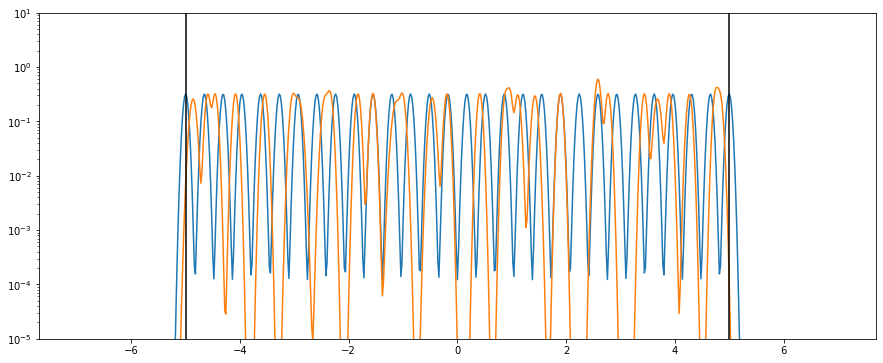

In [278]:

def pdf (x, fracs, means, widths) :
    assert len(means) == len(fracs)
    assert len(widths) == len(fracs)
    n_g, pdf = len(fracs), 0.
    for i in range(n_g) :
        pdf = pdf + fracs[i]*stats.norm.pdf(x, loc=means[i], scale=widths[i])
    return pdf

x  = np.linspace(-7, 7, 701)
y1 = pdf(x, f1, m1, w1)
y2 = pdf(x, f2, m2, w2)
y3 = pdf(x, f3, m3, w3)


fig = plt.figure(figsize=(15, 6))
ax  = fig.add_subplot(1, 1, 1)
#ax.plot(x, y1)
ax.plot(x, y2)
ax.plot(x, y3)
ax.axvline(-5, c="k")
ax.axvline(5 , c="k")
ax.set_yscale("log")
ax.set_ylim([1e-5, 1e1])
plt.show()
